# Question 3

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from numpy.linalg import matrix_rank

np.random.seed(7)
np.set_printoptions(suppress=True) # it suppresses the scientific notation for small numbers





In [10]:
def regularized_cov(X, alfa):
    """"
    Computes the regularized covariance matrix (useful in case there are ill-conditioned matrices)

    Parameters:
    - X: data (features x samples)
    - alfa: reg parameter (lambda = alfa * trace(C_sampleAverage)/rank(C_sampleAverage))

    Returns:
    - Reg cov matrix
    """

    # rowvar=False: If False, each column represents a feature, and the covariance is calculated across the rows (observations)
    C_sampleAverage = np.cov(X, rowvar = False)
    num_features = C_sampleAverage.shape[0]
    lambda_reg = alfa * np.trace(C_sampleAverage)/num_features
    C_regularized = C_sampleAverage + lambda_reg * np.eye(num_features)
    return C_regularized

def erm_classification(X, loss_matrix, priors, mean, cov, num_classes):
    """
    Performs Expected Risk Minimization classification to minimize the probability of error 
    (when the number of decisions is equal to the number of class labels)

    Parameters:
    - X: data (features x samples)
    - loss_matrix (d,l) (loss incurred by deciding d given a sample from class/label l)
    - priors, mean, cov (gaussian multivariate parameters)
    - num_classes

    Returns:
    - The predicted/ decided class labels for every sample to minimize the probability of error
    """

    # compute class conditionals (likelihoods) and posteriors (num_classes x num_samples) 
    class_conditional = np.array([multivariate_normal.pdf(X, mean[c], cov[c]) for c in range(num_classes)])
    print(class_conditional)

    posteriors = np.array([class_conditional[i] * priors[i] for i in range(num_classes)])
    # risk matrix (num_classes x num_samples)
    risk_matrix = loss_matrix @ posteriors

    return np.argmin(risk_matrix, axis=0)

### Wine Quality Dataset

[[0.00000005 0.00002165 0.00004485 ... 0.00000243 0.00000199 0.00000891]
 [0.00000224 0.00181962 0.00076034 ... 0.00041542 0.00001395 0.00016006]
 [0.00087147 0.0045192  0.00203636 ... 0.00126557 0.00000454 0.00022867]
 ...
 [0.00017352 0.0003183  0.00155765 ... 0.00004371 0.0149425  0.01498537]
 [0.00007771 0.00003037 0.00153502 ... 0.00001872 0.01493115 0.00795384]
 [0.         0.         0.         ... 0.         0.         0.        ]]


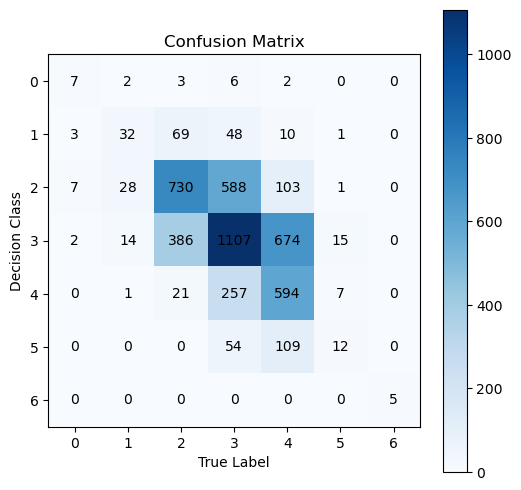

Error sample count: 2411
Empirically Estimated Probability of Error: 0.4922


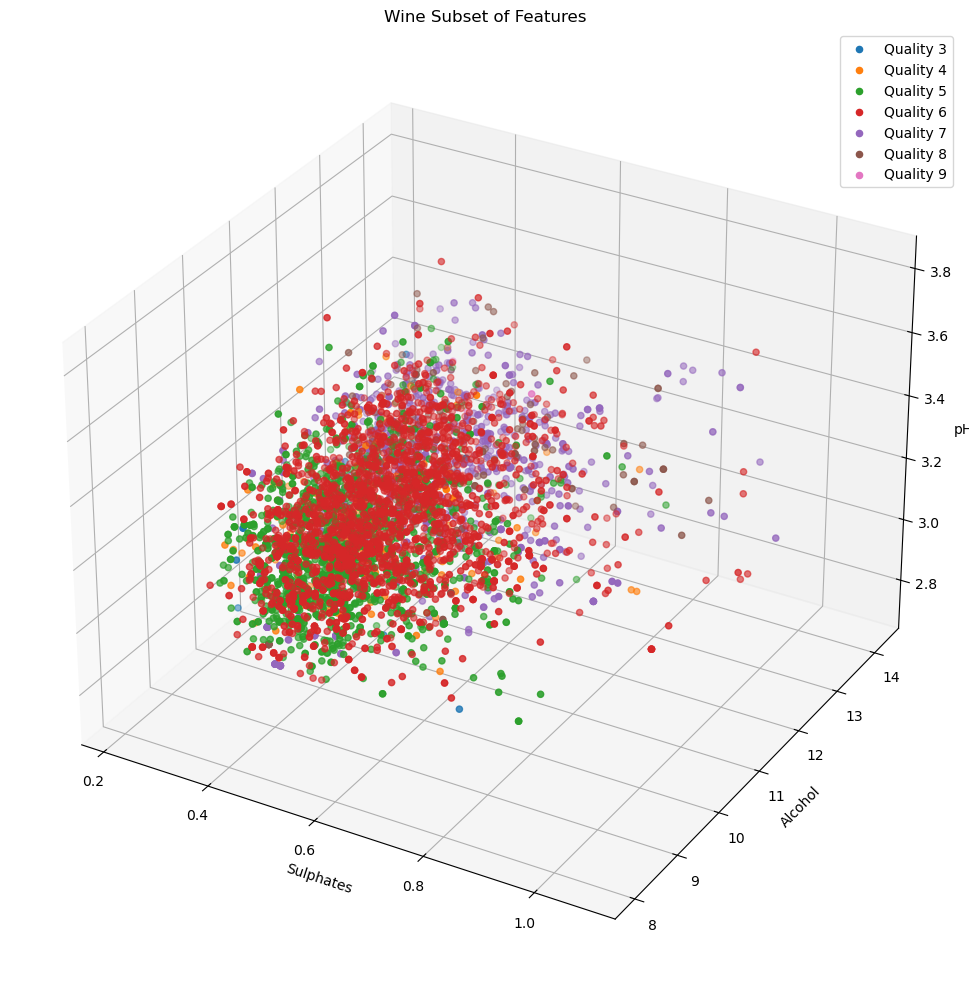

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


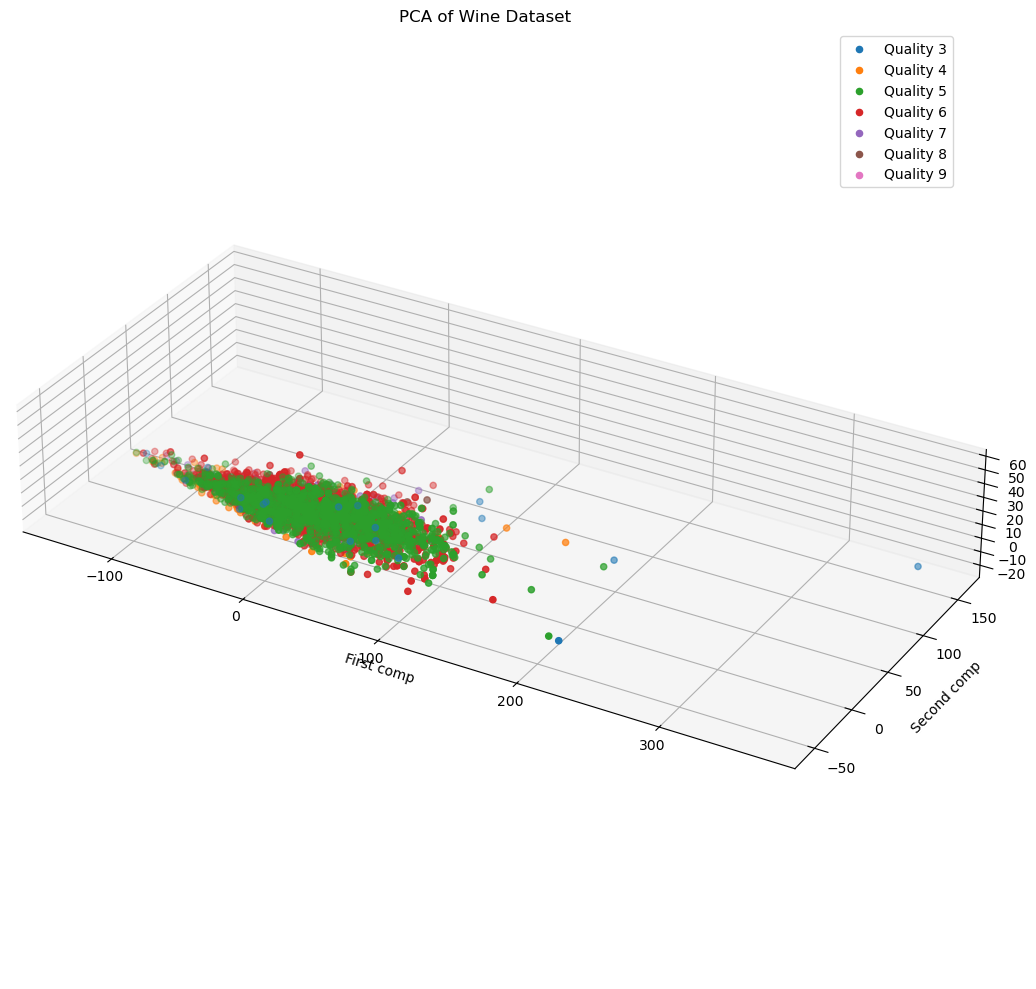

In [12]:
wine_df = pd.read_csv('dataset_question_3/wine/winequality-white.csv',
                       delimiter=';')

# extract data (features) and labels (last column)
X = wine_df.iloc[:, :-1].to_numpy()
labels = wine_df.iloc[:, -1].to_numpy()

# Encode labels using LabelEncoder
# https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

# class means, covariance matrix and priors estimates (with sample averages)
class_means = wine_df.groupby('quality').mean().to_numpy()
num_samples = wine_df.shape[0]
alfa = 0.00001
class_priors = wine_df.groupby('quality').size().to_numpy() / num_samples
num_classes = len(class_priors)
class_reg_cov_mat = np.array([regularized_cov(X[labels == l], alfa) for l in range(num_classes)])

# cost matrix for 0-1 loss
loss_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# perform Expected Risk Minimization classification to minimize the probability of error 
# and get the decision/predicted class labels for every sample
predicted_labels = erm_classification(X, loss_matrix, class_priors, class_means, class_reg_cov_mat, num_classes)

# compute confusion matrix
conf_matrix = confusion_matrix(predicted_labels, labels).T

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')

plt.title("Confusion Matrix")
plt.xlabel('True Label')
plt.ylabel('Decision Class')
plt.colorbar()

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()

num_errors = num_samples - np.sum(np.diag(conf_matrix))
print("Error sample count: {:d}".format(num_errors))

prob_error_estimate = num_errors/num_samples
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error_estimate))

# Visualization of the dataset in 3 dimensional chosen projections
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

unique_qualities = np.sort(wine_df['quality'].unique())

# Plot each quality level
for q in unique_qualities:
    quality_data = wine_df[wine_df['quality'] == q]
    ax.scatter(quality_data['sulphates'], quality_data['alcohol'], quality_data['pH'], label=f"Quality {q}")

plt.title("Wine Subset of Features")
plt.legend()
plt.tight_layout() # adjusts margins, padding, and spacing between subplots to make sure everything fits properly within the figure.

ax.set_xlabel("Sulphates")
ax.set_ylabel("Alcohol")
ax.set_zlabel("pH")

plt.show()

# Create a figure and a 3D subplot
fig = plt.figure(figsize=(10, 10))
ax_pca = fig.add_subplot(111, projection='3d')


# Visualization of the dataset in the 3 first components coming from the PCA
pca = PCA(n_components=3)  # we want the first 3 principal components
X_fit = pca.fit(X)
Z = pca.transform(X)  # Project the data into the principal component 3D space

print("Explained variance ratio: ", pca.explained_variance_ratio_)

unique_qualities = np.sort(wine_df['quality'].unique())

# Plot each quality level
for q in unique_qualities:
    quality_indices = wine_df['quality'] == q
    ax_pca.scatter(Z[quality_indices, 0], Z[quality_indices, 1], Z[quality_indices, 2], label=f"Quality {q}")

# Set equal aspect ratio for the 3D plot
ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()

ax_pca.set_xlabel("First comp")
ax_pca.set_ylabel("Second comp")
ax_pca.set_zlabel("Third comp")

plt.show()

### Human Activity Recognition Dataset

[[[ 0.03470987  0.00000912 -0.00012915 ... -0.00005273 -0.00002289
   -0.00011694]
  [ 0.00000912  0.03268597  0.00009181 ... -0.00002046  0.00001977
   -0.00009036]
  [-0.00012915  0.00009181  0.0332746  ...  0.0000274   0.0000512
    0.00006703]
  ...
  [-0.00005273 -0.00002046  0.0000274  ...  0.04199974  0.00424589
    0.00617855]
  [-0.00002289  0.00001977  0.0000512  ...  0.00424589  0.03662637
    0.0010116 ]
  [-0.00011694 -0.00009036  0.00006703 ...  0.00617855  0.0010116
    0.04415182]]

 [[ 0.03883501  0.00069585  0.00049806 ...  0.00002728  0.00016568
   -0.00052637]
  [ 0.00069585  0.0344465   0.00026912 ...  0.00063173  0.00011523
    0.0004105 ]
  [ 0.00049806  0.00026912  0.03645621 ...  0.00014165  0.00030954
   -0.00009703]
  ...
  [ 0.00002728  0.00063173  0.00014165 ...  0.04819007  0.00431474
    0.01300952]
  [ 0.00016568  0.00011523  0.00030954 ...  0.00431474  0.04027201
   -0.00065419]
  [-0.00052637  0.0004105  -0.00009703 ...  0.01300952 -0.00065419
    0.05

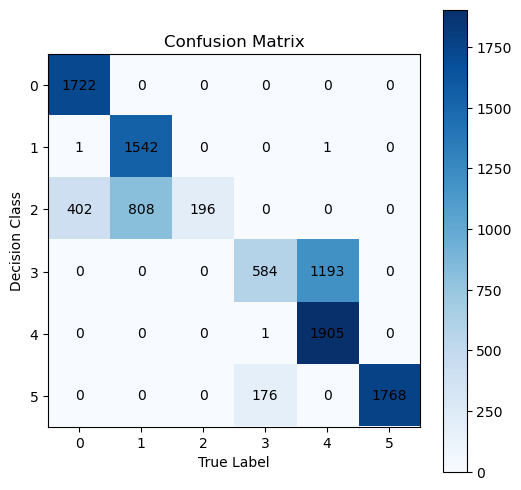

Error sample count: 2582
Empirically Estimated Probability of Error: 0.2507


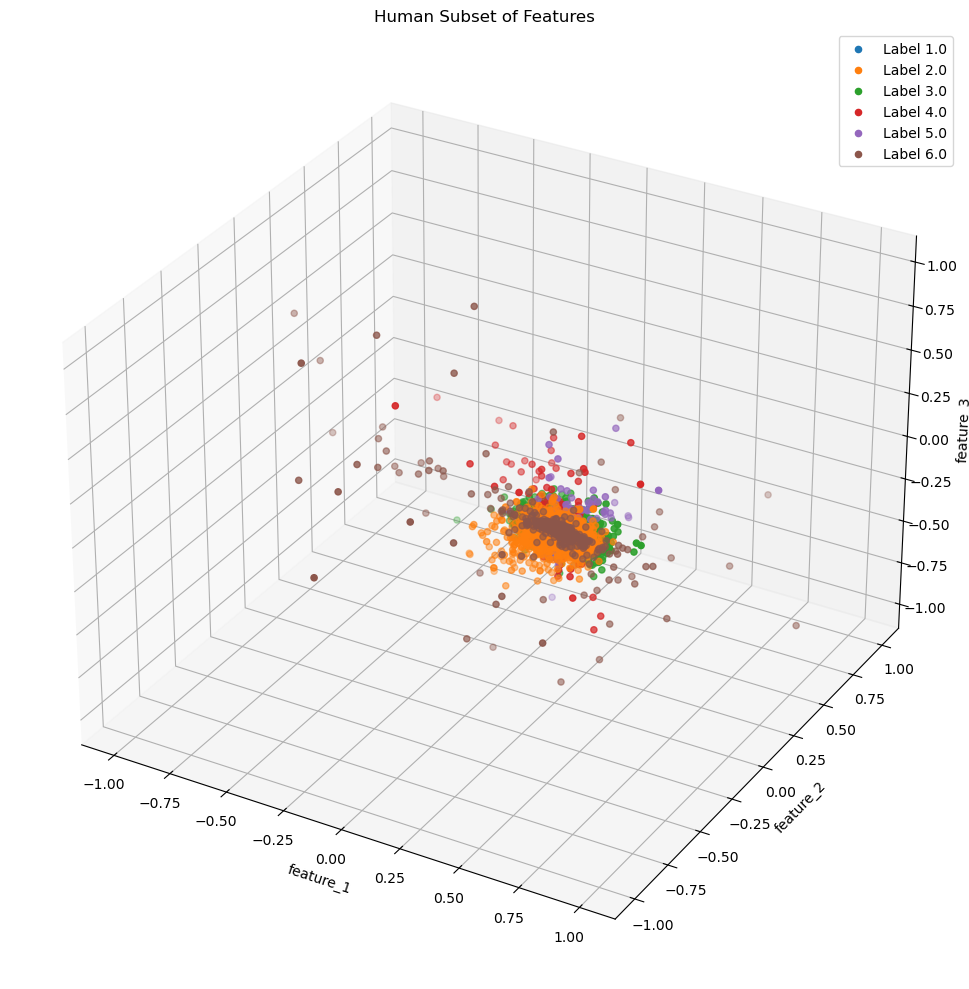

Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


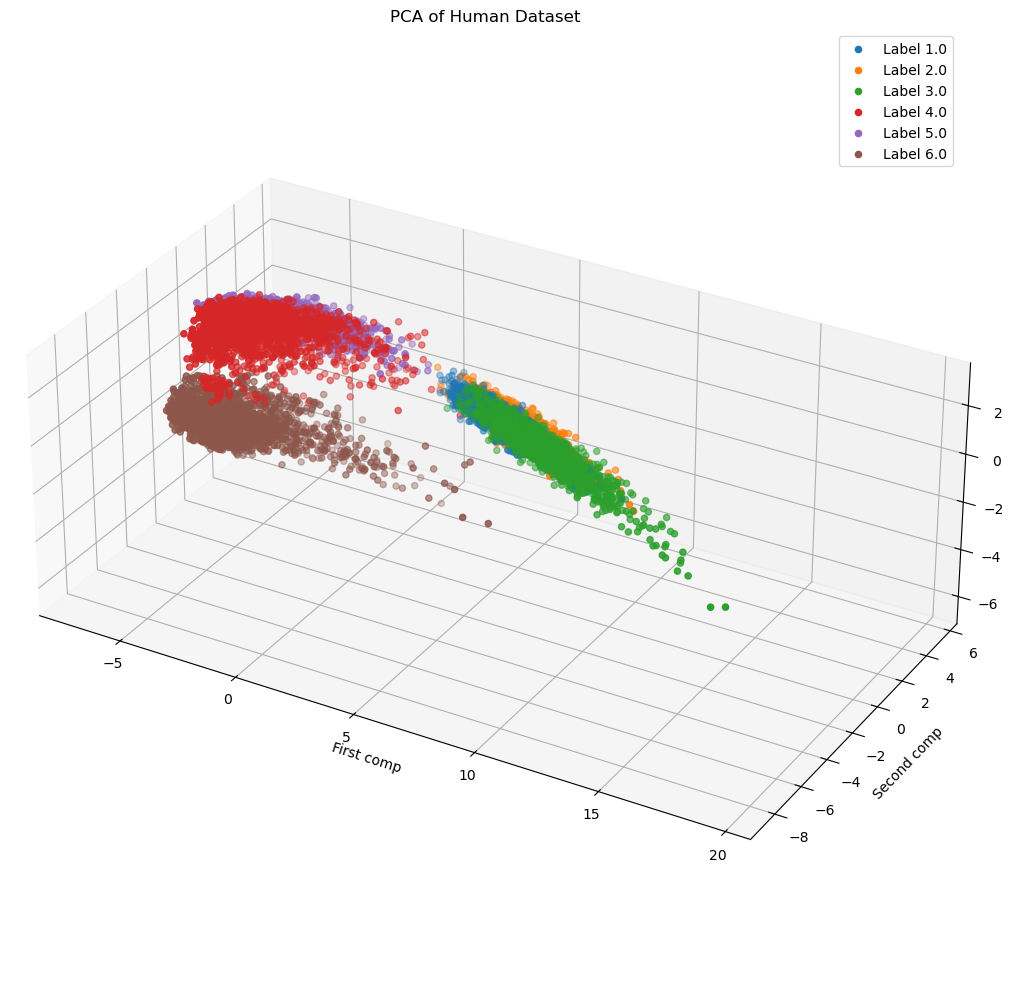

In [11]:
X_train = np.loadtxt('dataset_question_3/human/X_train.txt')
X_test = np.loadtxt('dataset_question_3/human/X_test.txt')
y_train = np.loadtxt('dataset_question_3/human/y_train.txt')
y_test = np.loadtxt('dataset_question_3/human/y_test.txt')

# Convert NumPy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
# Concatenate the training and test dataframes for X (features) and labels
X = pd.concat([X_train_df, X_test_df], ignore_index=True)
labels = pd.concat([y_train_df, y_test_df], ignore_index=True)
# Create headers for X (features) and labels
num_features = X.shape[1]  # Number of columns in X
feature_headers = [f'feature_{i+1}' for i in range(num_features)]
label_header = ['label']

# Assign the headers to X and labels
X.columns = feature_headers
labels.columns = label_header

# Combine X (features) and labels into one dataframe, with labels as the last column
human_df = pd.concat([X, labels], axis=1)

# extract data (features) and labels (last column)
X = human_df.iloc[:, :-1].to_numpy()
labels = human_df.iloc[:, -1].to_numpy()

# Encode labels using LabelEncoder
# https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)
unique_labels = np.unique(labels)

# class means, covariance matrix and priors estimates (with sample averages)
class_means = human_df.groupby('label').mean().to_numpy()
num_samples = human_df.shape[0]
alfa = 0.9
class_priors = human_df.groupby('label').size().to_numpy() / num_samples
num_classes = len(class_priors)
    
class_reg_cov_mat = np.array([regularized_cov(X[labels == l], alfa) for l in unique_labels])
print(class_reg_cov_mat)
# cost matrix for 0-1 loss
loss_matrix = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# perform Expected Risk Minimization classification to minimize the probability of error 
# and get the decision/predicted class labels for every sample
predicted_labels = erm_classification(X, loss_matrix, class_priors, class_means, class_reg_cov_mat, num_classes)

# compute confusion matrix
conf_matrix = confusion_matrix(predicted_labels, labels).T

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')

plt.title("Confusion Matrix")
plt.xlabel('True Label')
plt.ylabel('Decision Class')
plt.colorbar()

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()

num_errors = num_samples - np.sum(np.diag(conf_matrix))
print("Error sample count: {:d}".format(num_errors))

prob_error_estimate = num_errors/num_samples
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error_estimate))

# Visualization of the dataset in 3 dimensional chosen projections
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.sort(human_df['label'].unique())

# Plot each label level
for q in unique_labels:
    label_data = human_df[human_df['label'] == q]
    ax.scatter(label_data['feature_1'], label_data['feature_2'], label_data['feature_3'], label=f"Label {q}")

plt.title("Human Subset of Features")
plt.legend()
plt.tight_layout() # adjusts margins, padding, and spacing between subplots to make sure everything fits properly within the figure.

ax.set_xlabel("feature_1")
ax.set_ylabel("feature_2")
ax.set_zlabel("feature_3")

plt.show()

# Create a figure and a 3D subplot
fig = plt.figure(figsize=(10, 10))
ax_pca = fig.add_subplot(111, projection='3d')


# Visualization of the dataset in the 3 first components coming from the PCA
pca = PCA(n_components=3)  # we want the first 3 principal components
X_fit = pca.fit(X)
Z = pca.transform(X)  # Project the data into the principal component 3D space

print("Explained variance ratio: ", pca.explained_variance_ratio_)

# Plot each label level
for q in unique_labels:
    label_indices = human_df['label'] == q
    ax_pca.scatter(Z[label_indices, 0], Z[label_indices, 1], Z[label_indices, 2], label=f"Label {q}")

# Set equal aspect ratio for the 3D plot
ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Human Dataset")
plt.legend()
plt.tight_layout()

ax_pca.set_xlabel("First comp")
ax_pca.set_ylabel("Second comp")
ax_pca.set_zlabel("Third comp")

plt.show()
